# TSA-Temperature-Forecast

## 1. Get and clean temperature data from www.ecad.eu.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize']=(12,6)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg

In [2]:
df=pd.read_csv('./ECA_blended_custom/TG_STAID002759.txt',delimiter=',', skiprows=19,index_col = 1,parse_dates=True)


In [3]:
df


,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2021-05-27,111448,118,0
2021-05-28,111448,116,0
2021-05-29,111448,125,0


In [4]:
df.reset_index(inplace=True)

In [5]:
df.columns

Index(['    DATE', ' SOUID', '   TG', ' Q_TG'], dtype='object')

In [6]:
#rename the columns
df = df.rename({'   TG': 'TG', '    DATE': 'DATE'}, axis=1)

<ipython-input-7-41b537688110>:8: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='year 1945',xy=(25296,-10000),xytext=(30301,-8000),weight='bold',color='aqua',\


Text(30301, -8000, 'year 1945')

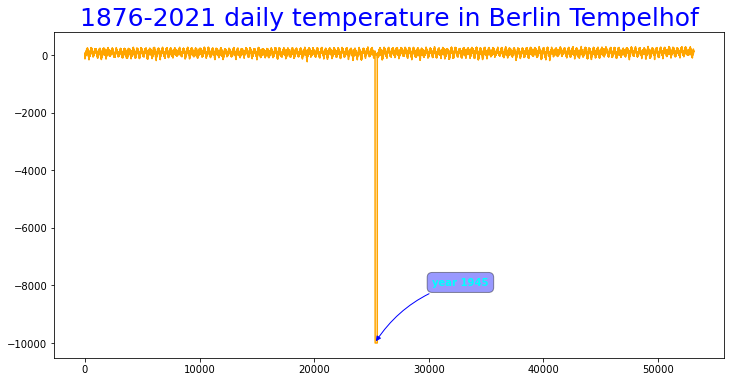

In [7]:
#plot the data
x=df.index
y=df['TG']

plt.title('1876-2021 daily temperature in Berlin Tempelhof', fontsize = 25,color='blue')

plt.plot(x,y,linestyle='-',color='orange')
plt.annotate(s='year 1945',xy=(25296,-10000),xytext=(30301,-8000),weight='bold',color='aqua',\
             arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3,rad = .2',color='blue'),\
            bbox=dict(boxstyle='round,pad=0.5', fc='blue', ec='k',lw=1 ,alpha=0.4))



In [8]:

#cols=[x for x in enumerate(df[' Q_TG']) if df[' Q_TG'] !=0]

df_b = df.drop(df[df[' Q_TG']!=0].index)

# df_c = df.drop(df[<some boolean condition>].index)

#df_c=df.drop(df[' Q_TG']=[df[' Q_TG'] !=0].index)
#df_clear = df.drop(df[(df['x']<0.01) | (df['x']>10)].index)

In [109]:
len(df_b)

52916

In [110]:
#delete the year 1945 data, because several months' data  missed.
df_c = df[~((df['DATE'] >= '1945-01-01') & (df['DATE'] <= '1946-12-31'))]

In [11]:
#df = df[~((df['DATE'] >= '1876-01-01') & (df['DATE'] <= '1876-01-03'))]

Text(0.5, 1.0, '1876-2021 daily temperature in Berlin Tempelhof')

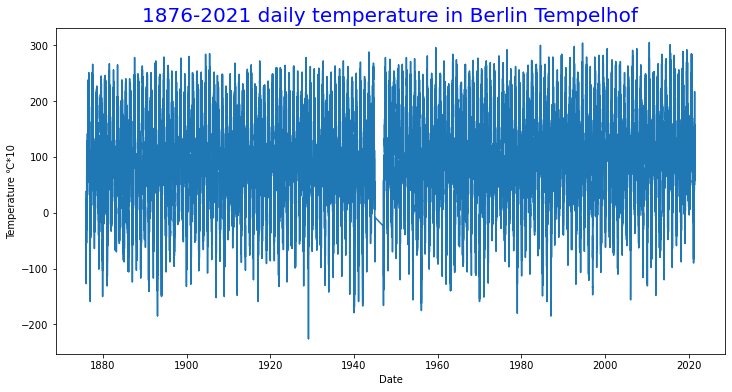

In [200]:

X=df_c['DATE']
y=df_c['TG']
plt.plot(X,y)
plt.xlabel('Date')
plt.ylabel('Temperature ℃*10')
plt.title('1876-2021 daily temperature in Berlin Tempelhof', fontsize = 20,color='blue')

In [112]:
df_c['time_step']=range(len(df_c))

<ipython-input-112-ba34e502eff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['time_step']=range(len(df_c))


In [113]:
# drop the useless columns
df_c.columns
dfc=df_c.drop(columns=[' SOUID',' Q_TG'],index=1)

In [114]:
dfc



,DATE,TG,time_step
0,1876-01-01,22,0
2,1876-01-03,3,2
3,1876-01-04,-58,3
4,1876-01-05,-98,4
5,1876-01-06,-77,5
...,...,...,...
53107,2021-05-27,118,52377
53108,2021-05-28,116,52378
53109,2021-05-29,125,52379
53110,2021-05-30,139,52380


In [16]:
dfc.dtypes

DATE         datetime64[ns]
TG                    int64
time_step             int64
dtype: object

In [115]:
dfc.set_index(['DATE'],inplace=True)

In [116]:
dfc

,TG,time_step
DATE,,
1876-01-01,22,0
1876-01-03,3,2
1876-01-04,-58,3
1876-01-05,-98,4
1876-01-06,-77,5
...,...,...
2021-05-27,118,52377
2021-05-28,116,52378
2021-05-29,125,52379


## 2. Build a baseline model to model the trend and seasonality.

In [117]:
#Add season dummies feature by using month value

season_dummies=pd.get_dummies(dfc.index.month, prefix='month',drop_first=False).set_index(dfc.index)


In [20]:
season_dummies

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-06,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-28,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-29,0,0,0,0,1,0,0,0,0,0,0,0


In [21]:
season_dummies.index

DatetimeIndex(['1876-01-01', '1876-01-03', '1876-01-04', '1876-01-05',
               '1876-01-06', '1876-01-07', '1876-01-08', '1876-01-09',
               '1876-01-10', '1876-01-11',
               ...
               '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
               '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
               '2021-05-30', '2021-05-31'],
              dtype='datetime64[ns]', name='DATE', length=52381, freq=None)

In [118]:
dfcc=dfc.join(season_dummies)

In [23]:
dfcc

,TG,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
1876-01-01,22,0,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,3,2,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-58,3,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-98,4,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-06,-77,5,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,118,52377,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-28,116,52378,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-29,125,52379,0,0,0,0,1,0,0,0,0,0,0,0


In [119]:

#train-test split
df_tr=dfcc[:-10000]
df_te=dfcc[-10000:]
season_dummies_tr=season_dummies[:-10000]

In [120]:
df_tr.columns

Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [133]:
X=df_tr[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12']]
y=df_tr['TG']

In [134]:
y

DATE
1876-01-01    22
1876-01-03     3
1876-01-04   -58
1876-01-05   -98
1876-01-06   -77
              ..
1994-01-09    14
1994-01-10    22
1994-01-11    24
1994-01-12    62
1994-01-13    88
Name: TG, Length: 42381, dtype: int64

In [135]:
m=LinearRegression()
m.fit(X,y)

LinearRegression()

In [136]:
y_p=m.predict(X)
df_tr['y_p']=y_p

<ipython-input-136-5e9f09989680>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['y_p']=y_p


<AxesSubplot:xlabel='DATE'>

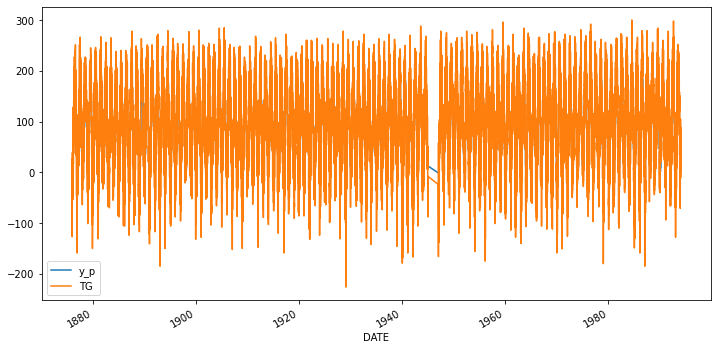

In [137]:
df_tr[['y_p','TG']].plot()

In [138]:
df_tr[['y_p','TG']]

,y_p,TG
DATE,,
1876-01-01,-5.892678,22
1876-01-03,-5.892331,3
1876-01-04,-5.892158,-58
1876-01-05,-5.891984,-98
1876-01-06,-5.891811,-77
...,...,...
1994-01-09,1.452374,14
1994-01-10,1.452547,22
1994-01-11,1.452720,24


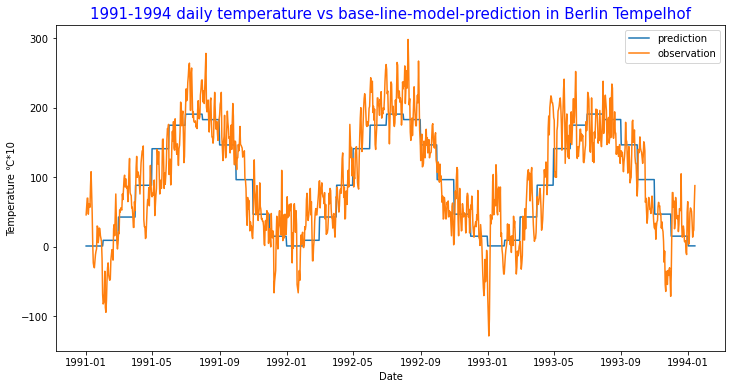

In [213]:
#df_tr[(df_tr.index >= '1991-01-01') ][['y_p','TG']].plot(label=('prediction','observation'))

y1=df_tr[(df_tr.index >= '1991-01-01') ]['y_p']
y2=df_tr[(df_tr.index >= '1991-01-01') ]['TG']
x=df_tr[(df_tr.index >= '1991-01-01') ].index
plt.plot(x, y1, label='prediction')
plt.plot(x, y2, label='observation')
plt.xlabel('Date')
plt.ylabel('Temperature ℃*10')
plt.title('1991-1994 daily temperature vs base-line-model-prediction in Berlin Tempelhof', fontsize = 15,color='blue')
plt.legend()

In [140]:
m.score(X,y)

0.7507854171803987

## 3. Plot and inspect the different components of a time series

In [141]:
#add remainder column
df_tr['remainder']=df_tr['TG']-df_tr['y_p']

<ipython-input-141-535178b7448b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['remainder']=df_tr['TG']-df_tr['y_p']


<AxesSubplot:xlabel='DATE'>

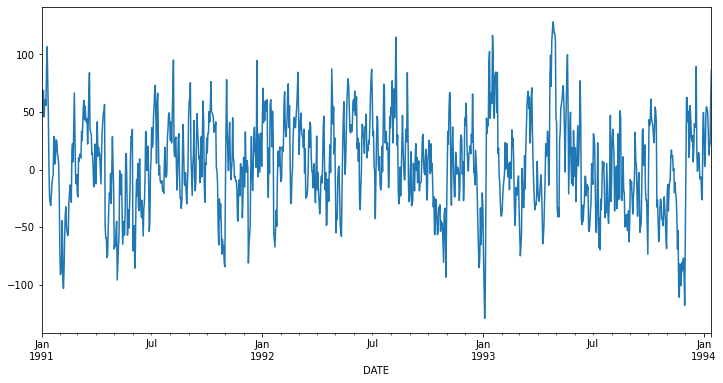

In [142]:
df_tr[(df_tr.index >= '1991-01-01') ]['remainder'].plot()

In [36]:
#df_tr.isna().sum()

In [37]:
#plt.scatter(data=df_tr[(df_tr.index >= '1991-01-01') ],x='DATE',y='remainder')

In [143]:
df_tr['lag1']=df_tr['remainder'].shift(1)

<ipython-input-143-4ea518befe09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['lag1']=df_tr['remainder'].shift(1)


In [144]:
df_tr

,TG,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y_p,remainder,lag1
DATE,,,,,,,,,,,,,,,,,
1876-01-01,22,0,1,0,0,0,0,0,0,0,0,0,0,0,-5.892678,27.892678,NaN
1876-01-03,3,2,1,0,0,0,0,0,0,0,0,0,0,0,-5.892331,8.892331,27.892678
1876-01-04,-58,3,1,0,0,0,0,0,0,0,0,0,0,0,-5.892158,-52.107842,8.892331
1876-01-05,-98,4,1,0,0,0,0,0,0,0,0,0,0,0,-5.891984,-92.108016,-52.107842
1876-01-06,-77,5,1,0,0,0,0,0,0,0,0,0,0,0,-5.891811,-71.108189,-92.108016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-01-09,14,42377,1,0,0,0,0,0,0,0,0,0,0,0,1.452374,12.547626,33.547800
1994-01-10,22,42378,1,0,0,0,0,0,0,0,0,0,0,0,1.452547,20.547453,12.547626
1994-01-11,24,42379,1,0,0,0,0,0,0,0,0,0,0,0,1.452720,22.547280,20.547453


In [145]:
df_trn=df_tr.dropna()


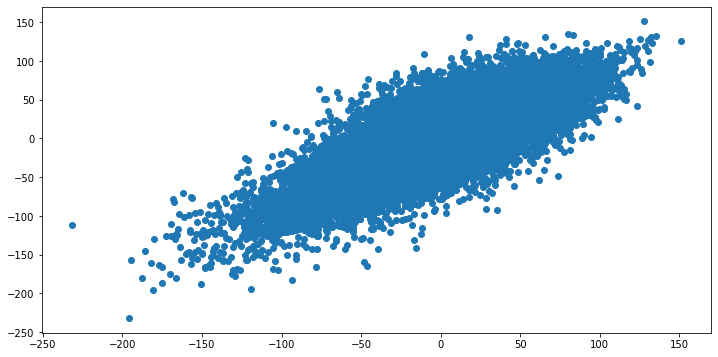

In [146]:
plt.scatter(x='remainder',y='lag1',data=df_trn)

In [147]:
df_trn[['remainder','lag1']].corr()

,remainder,lag1
remainder,1.000000,0.800893
lag1,0.800893,1.000000


In [148]:
X=df_trn[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12','lag1']]
y=df_trn['TG']

In [149]:
n=LinearRegression()

In [150]:
n.fit(X,y)

LinearRegression()

In [151]:
df_trn['y_p1']=n.predict(X)

<ipython-input-151-74a5aeb64955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn['y_p1']=n.predict(X)


<AxesSubplot:xlabel='DATE'>

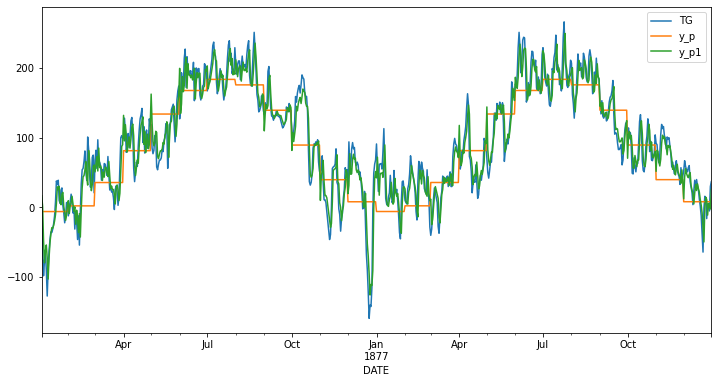

In [152]:
df_trn[df_trn.index<'1878'][['TG','y_p','y_p1']].plot()

In [153]:
n.score(X,y)

0.9106508249728461

In [154]:

df_trn['lag2']=df_trn['remainder'].shift(2)

<ipython-input-154-99de108ddcb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn['lag2']=df_trn['remainder'].shift(2)


In [155]:
df_trnn=df_trn.dropna()

In [156]:
X=df_trnn[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12','lag1','lag2']]
y=df_trnn['TG']

In [157]:
o=LinearRegression()

In [158]:
o.fit(X,y)

LinearRegression()

In [159]:
o.score(X,y)

0.9120688146269234

#  cross validation

In [55]:
#Create a TimeSeriesSplit object
ts_split=TimeSeriesSplit(n_splits=5)

In [56]:
time_series_split=ts_split.split(X,y)

In [57]:
result = cross_val_score(estimator=o, X=X,y=y, cv=time_series_split)

In [58]:
o.score(X,y)

0.9120688146269234

In [59]:
result

array([0.91183051, 0.90033954, 0.91522939, 0.9118589 , 0.90769371])

In [160]:
round(result.mean(),3)

0.909

## validating the model on test data

In [161]:
last_time_step=df_trnn['time_step'][-1]



In [62]:
last_time_step

42381

In [63]:
df_te.columns

Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [162]:
Xt

,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1994-01-14,42382,1,0,0,0,0,0,0,0,0,0,0,0
1994-01-15,42383,1,0,0,0,0,0,0,0,0,0,0,0
1994-01-16,42384,1,0,0,0,0,0,0,0,0,0,0,0
1994-01-17,42385,1,0,0,0,0,0,0,0,0,0,0,0
1994-01-18,42386,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,52377,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-28,52378,0,0,0,0,1,0,0,0,0,0,0,0
2021-05-29,52379,0,0,0,0,1,0,0,0,0,0,0,0


In [64]:
Xt=df_te[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12']]

In [65]:
yt=df_te['TG']

In [66]:
df_te['trend_seasonal']=m.predict(Xt)

<ipython-input-66-9f266f120af0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['trend_seasonal']=m.predict(Xt)


In [67]:
df_te['remainder']=df_te['TG']-df_te['trend_seasonal']

<ipython-input-67-cb3aa29693bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['remainder']=df_te['TG']-df_te['trend_seasonal']


In [68]:
# Add lag feature — for test data
df_te['lag1'] = df_te['remainder'].shift(1)

<ipython-input-68-a781faa293ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['lag1'] = df_te['remainder'].shift(1)


In [69]:
df_te_n=df_te.dropna()

In [70]:
 Xtf=df_te_n[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12','lag1']]

In [71]:
Xtf

,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,,
1994-01-15,42383,1,0,0,0,0,0,0,0,0,0,0,0,62.546760
1994-01-16,42384,1,0,0,0,0,0,0,0,0,0,0,0,42.546586
1994-01-17,42385,1,0,0,0,0,0,0,0,0,0,0,0,5.546413
1994-01-18,42386,1,0,0,0,0,0,0,0,0,0,0,0,-21.453760
1994-01-19,42387,1,0,0,0,0,0,0,0,0,0,0,0,-1.453934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,52377,0,0,0,0,1,0,0,0,0,0,0,0,-18.925959
2021-05-28,52378,0,0,0,0,1,0,0,0,0,0,0,0,-24.926132
2021-05-29,52379,0,0,0,0,1,0,0,0,0,0,0,0,-26.926305


In [72]:
df_te_n['yt_p']=n.predict(Xtf)

<ipython-input-72-c9aa805b0fe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te_n['yt_p']=n.predict(Xtf)


In [73]:
df_te_n

,TG,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,yt_p
DATE,,,,,,,,,,,,,,,,,,
1994-01-15,44,42383,1,0,0,0,0,0,0,0,0,0,0,0,1.453414,42.546586,62.546760,51.846726
1994-01-16,7,42384,1,0,0,0,0,0,0,0,0,0,0,0,1.453587,5.546413,42.546586,35.826832
1994-01-17,-20,42385,1,0,0,0,0,0,0,0,0,0,0,0,1.453760,-21.453760,5.546413,6.189998
1994-01-18,0,42386,1,0,0,0,0,0,0,0,0,0,0,0,1.453934,-1.453934,-21.453760,-15.436872
1994-01-19,21,42387,1,0,0,0,0,0,0,0,0,0,0,0,1.454107,19.545893,-1.453934,0.583092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,118,52377,0,0,0,0,1,0,0,0,0,0,0,0,142.926132,-24.926132,-18.925959,127.826274
2021-05-28,116,52378,0,0,0,0,1,0,0,0,0,0,0,0,142.926305,-26.926305,-24.926132,123.020330
2021-05-29,125,52379,0,0,0,0,1,0,0,0,0,0,0,0,142.926479,-17.926479,-26.926305,121.418372


R2 score on test data

In [74]:

n.score(Xtf,df_te_n['TG'])

0.9148695723862207

In [75]:
n.coef_

array([ 1.73696582e-04, -9.31447112e+01, -8.49102080e+01, -5.15474315e+01,
       -6.25351746e+00,  4.63582726e+01,  7.96738937e+01,  9.57966496e+01,
        8.76195817e+01,  5.15788921e+01,  1.61761900e+00, -4.75277797e+01,
       -7.92612608e+01,  8.00996465e-01])

In [76]:
n.intercept_

87.52992181589006

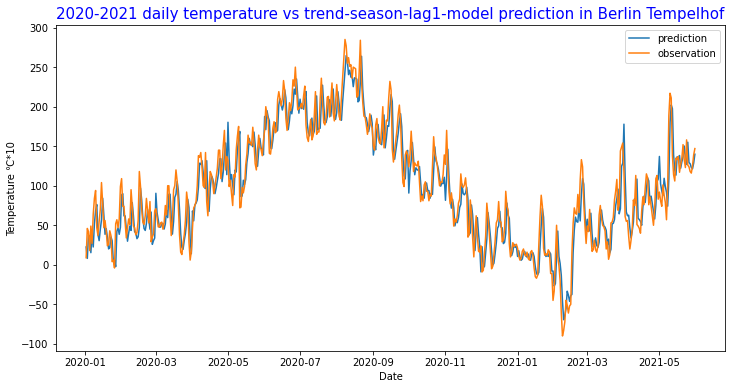

In [215]:
#df_te_n[df_te_n.index>'2020'][['TG','yt_p']].plot()



y1=df_te_n[df_te_n.index>'2020']['yt_p']
y2=df_te_n[df_te_n.index>'2020']['TG']
x=df_te_n[df_te_n.index>'2020'].index
plt.plot(x, y1, label='prediction')
plt.plot(x, y2, label='observation')
plt.xlabel('Date')
plt.ylabel('Temperature ℃*10')
plt.title('2020-2021 daily temperature vs trend-season-lag1-model prediction in Berlin Tempelhof', fontsize = 15,color='blue')
plt.legend()



## Combine the train set and test set of data and retrain the model


In [78]:
df_tr.columns

Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'y_p', 'remainder', 'lag1'],
      dtype='object')

In [79]:
df_te.columns

Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'trend_seasonal', 'remainder', 'lag1'],
      dtype='object')

In [80]:
df_tr.rename(columns={'y_p':'trend_seasonal'},inplace=True)

/home/baodong/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [81]:
#combine the dataset

In [82]:
df_combined=df_tr.append(df_te)

In [83]:
df_combined.columns

Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'trend_seasonal', 'remainder', 'lag1'],
      dtype='object')

In [84]:
df_combined.dropna(inplace=True)

In [85]:
# Re-train the model on the whole dataset
X_combined = df_combined[['time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'lag1']]
y_combined = df_combined['TG']

In [86]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [87]:
df_combined

,TG,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,,
1876-01-03,3,2,1,0,0,0,0,0,0,0,0,0,0,0,-5.892331,8.892331,27.892678
1876-01-04,-58,3,1,0,0,0,0,0,0,0,0,0,0,0,-5.892158,-52.107842,8.892331
1876-01-05,-98,4,1,0,0,0,0,0,0,0,0,0,0,0,-5.891984,-92.108016,-52.107842
1876-01-06,-77,5,1,0,0,0,0,0,0,0,0,0,0,0,-5.891811,-71.108189,-92.108016
1876-01-07,-66,6,1,0,0,0,0,0,0,0,0,0,0,0,-5.891638,-60.108362,-71.108189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,118,52377,0,0,0,0,1,0,0,0,0,0,0,0,142.926132,-24.926132,-18.925959
2021-05-28,116,52378,0,0,0,0,1,0,0,0,0,0,0,0,142.926305,-26.926305,-24.926132
2021-05-29,125,52379,0,0,0,0,1,0,0,0,0,0,0,0,142.926479,-17.926479,-26.926305


# predict the temperature of future which not contained in our data set (2021-6-1)

In [88]:
time_step = df_combined['time_step'].max() + 1
# lag for the new datapoint/row is the remainder in the last row of the combined dataset
lag = df_combined.loc['2021-05-31', 'remainder']


In [89]:
#get the month dummies for 2021-06-01. we take the dummies feature from 2020-06-01
month=df_combined.loc['2020-6-1'][2:14].values.tolist()


In [90]:
# Create a future data point
X_future1 = []
X_future1.append(time_step)
X_future1.extend(month)
X_future1.append(lag)


In [91]:
X_future1

[52382,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.073174655967591]

In [92]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

In [93]:
X_future1

,time_step,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,52382,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.073175


In [94]:
m_combined.predict(X_future1)

array([180.58370787])

In [95]:
#!pip install pmdarima

In [181]:
import statsmodels
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima

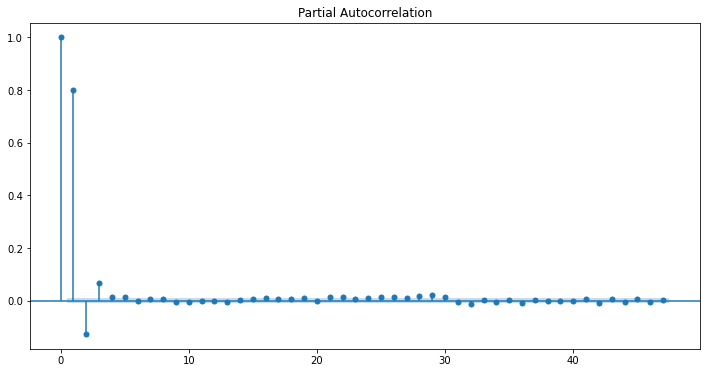

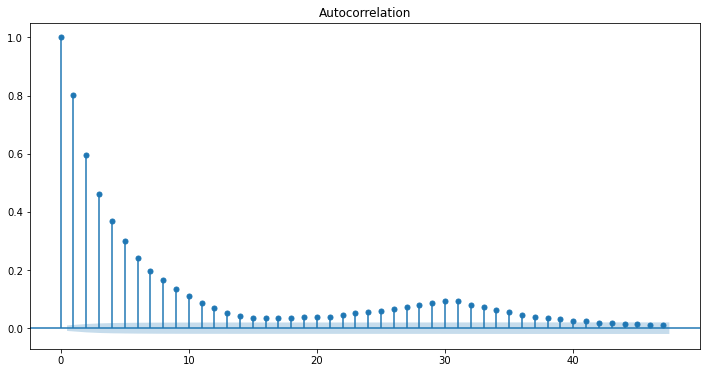

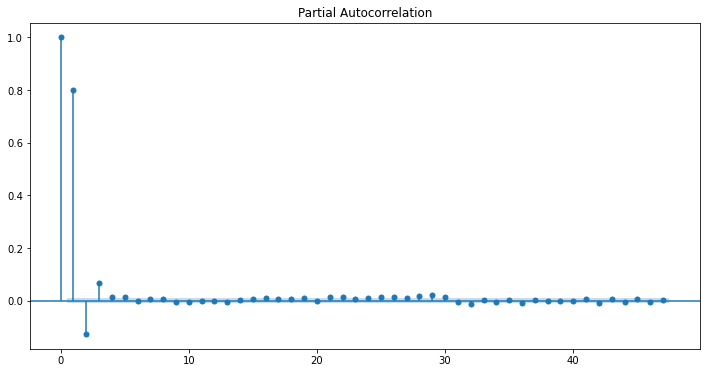

In [216]:
plot_acf(df_tr['remainder'])
plot_pacf(df_tr['remainder'])

In [98]:
# Use ar_select_order
order=ar_select_order(df_tr['remainder'], maxlag=20, old_names=False)

/home/baodong/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/baodong/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [99]:
order.ar_lags

array([1, 2, 3])

In [100]:
df_tr['remainder']

DATE
1876-01-01    27.892678
1876-01-03     8.892331
1876-01-04   -52.107842
1876-01-05   -92.108016
1876-01-06   -71.108189
                ...    
1994-01-09    12.547626
1994-01-10    20.547453
1994-01-11    22.547280
1994-01-12    60.547106
1994-01-13    86.546933
Name: remainder, Length: 42381, dtype: float64

In [101]:
df_tr.columns


Index(['TG', 'time_step', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'trend_seasonal', 'remainder', 'lag1'],
      dtype='object')

In [185]:
df_trnnn=df_tr[['TG']] 

In [186]:
df_trnnn.index = pd.DatetimeIndex(df_trnnn.index).to_period('D')

In [187]:
df_trnnn

,TG
DATE,
1876-01-01,22
1876-01-03,3
1876-01-04,-58
1876-01-05,-98
1876-01-06,-77
...,...
1994-01-09,14
1994-01-10,22
1994-01-11,24


In [188]:
ar_model=AutoReg(df_trnnn,lags=3, old_names=False).fit()



In [191]:
# question: where is the X input value?

df_trnnn['areg_pre']=ar_model.predict()

<ipython-input-191-40edf308fa83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trnnn['areg_pre']=ar_model.predict()


In [192]:
df_trnnn

,TG,areg_pre
DATE,,
1876-01-01,22,NaN
1876-01-03,3,NaN
1876-01-04,-58,NaN
1876-01-05,-98,-51.418215
1876-01-06,-77,-82.224215
...,...,...
1994-01-09,14,37.124710
1994-01-10,22,18.839759
1994-01-11,24,28.526080


In [193]:
df_trnnn.set_index(df_tr.index)

,TG,areg_pre
DATE,,
1876-01-01,22,NaN
1876-01-03,3,NaN
1876-01-04,-58,NaN
1876-01-05,-98,-51.418215
1876-01-06,-77,-82.224215
...,...,...
1994-01-09,14,37.124710
1994-01-10,22,18.839759
1994-01-11,24,28.526080


In [194]:
df_trnnn.dropna(inplace=True)

<ipython-input-194-592347bcd620>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trnnn.dropna(inplace=True)


In [195]:
import sklearn
from sklearn.metrics import r2_score
sklearn.metrics.r2_score(df_trnnn['TG'], df_trnnn['areg_pre'])

0.9114065429698787

In [172]:
df_trnnn

,TG,areg_pre
DATE,,
1876-01-06,-77,-80.589376
1876-01-07,-66,-58.628132
1876-01-08,-89,-59.758196
1876-01-09,-127,-86.325995
1876-01-10,-89,-117.029251
...,...,...
1994-01-09,14,37.372673
1994-01-10,22,19.184355
1994-01-11,24,29.505237


In [ ]:
df_trnnn.drop('TG',axis=1,inplace=True)

In [ ]:
df_tr=df_tr.join(df_trnnn)

question:why after join the value become NAN?

In [ ]:
df_tr

In [ ]:
# Plot the prediction
# df_tr[df_tr.index<'1878'][['TG']].plot()
# question
#plt.plot(df_trnnn['areg_pre'], label='ar_predictions')

## validate the AutoReg model on test data

In [ ]:
df_trnnn
Xtf,df_te_n

In [176]:
ar_model

In [226]:
# question how to validate in the test data?
#df_te_n['autoreg_pre']=ar_model.predict(Xtf)

## Use auto_arima to determin the best combination of p, q and d

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
#auto_arima_model = auto_arima(df_tr['remainder'],start_p=0,start_q=0,max_p=6, max_q=3)

In [ ]:
#auto_arima_model

We decide to choose lag=3 according to the PACF plot

In [ ]:
#arima_model=ARIMA(df_tr['TG'],order=(3,0,0),trend='ct',exog=season_dummies_tr).fit()

In [ ]:
# plt.plot(df_tr[df_tr.index <'1877']['TG'], label='temperature')
#question
# #plt.plot(arima_model.predict()[arima_model.predict().index < '1877'],label='arima_predictions')
# plt.legend()

In [217]:
import folium

In [225]:
m = folium.Map(
    location=[52.4532,13.3846],
   # tiles='Stamen Terrain',
    zoom_start=12
)

folium.Marker(
    [52.4532,13.3846],
    popup='TSA-Temperature-Forecasting for Tempelhof Berlin'
).add_to(m)

m.add_child(folium.ClickForMarker(popup='Waypoint'))

m



In [223]:
m = folium.Map(location=[52.4532,13.3846],zoom_start=13)
#tiles='Stamen Terrain'

m.add_child(folium.LatLngPopup())

m

In [220]:
data = (
    np.random.normal(size=(100, 3)) *
    np.array([[0.1, 0.1, 0.1]]) +
    np.array([[40, 116.5, 1]])
).tolist()
data[:3]

[[40.049423852531206, 116.45022170141533, 1.0582268081023976],
 [40.10719678116264, 116.58303088791645, 0.9578841261551936],
 [40.06978374429488, 116.53003820968655, 1.0998091055942496]]

In [221]:
#import geopandas as gpd
import pandas as pd
import folium, branca

#